In [1]:
import os
import torch
import torch.nn as nn
from einops import rearrange
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings
from video_dataset import VideoFrameDataset, ImglistToTensor

In [2]:
root = '/Users/luiginoto/Downloads/Dataset_Student/train/data/'
annotation_file = '/Users/luiginoto/Downloads/Dataset_Student/train/annotations.txt'

In [3]:
root = '../Dataset/Dataset_Student/train/data/'
annotation_file = '../Dataset/Dataset_Student/train/annotations.txt'

In [2]:
root = '/train/data/'
annotation_file = '/train/annotations.txt'

In [3]:
# transform_train = transforms.Compose([
#     #transforms.RandomCrop(32, padding=4),
#     transforms.Resize((128,128)),
#     #transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        # transforms.Resize(299),  # image batch, resize smaller edge to 299
        transforms.Resize((128,128)),
        # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [4]:
dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    mask=True,
    test_mode=False
)

In [5]:
sample = dataset[0] 
frames = sample[0]

In [6]:
len(sample)

3

In [7]:
mask = sample[2]
mask.shape

torch.Size([22, 160, 240])

In [8]:
frames.shape

torch.Size([22, 3, 128, 128])

/tmp/ipykernel_1705/1220864285.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3053.)
  plt.imshow(torch.transpose(frames[0],1,2).T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


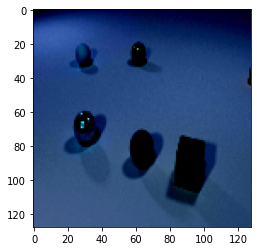

In [9]:
import matplotlib.pyplot as plt
plt.imshow(torch.transpose(frames[0],1,2).T)

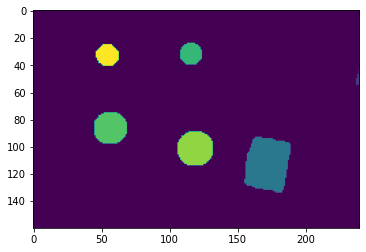

In [10]:
plt.imshow(mask[0])

In [5]:
dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

In [12]:
dataloader

In [13]:
data, target, mask = next(iter(dataloader))

In [14]:
data.shape

torch.Size([2, 22, 3, 128, 128])

In [6]:
from models import IJEPA_base, CustomDataParallel, EarlyStop

- Get patch embed for each frame of video
- Split into context and target with: context first 11 frames, target all frames (or context first frame oatches + random subsequent patches)
- Add learnable spatial-temporal positional embedding
- Feed context and target into context encoder and target encoder
- Input 11 mask token and context representation to predictor (ViT)
- 

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
encoder = IJEPA_base(img_size=128, patch_size=16, in_chans=3, norm_layer=nn.LayerNorm, num_frames=22, attention_type='joint_space_time', dropout=0.1, mode="test", r=0.5, embed_dim=768, device=device,
                        # encoder parameters
                        enc_depth=4,
                        enc_num_heads=6,
                        enc_mlp_ratio=4.,
                        enc_qkv_bias=False,
                        enc_qk_scale=None,
                        enc_drop_rate=0.,
                        enc_attn_drop_rate=0.,
                        enc_drop_path_rate=0.1,
                        # predictor parameters
                        pred_depth=4,
                        pred_num_heads=6,
                        pred_mlp_ratio=4.,
                        pred_qkv_bias=False,
                        pred_qk_scale=None,
                        pred_drop_rate=0.1,
                        pred_attn_drop_rate=0.1,
                        pred_drop_path_rate=0.1,
                        # positional and spacial embedding parameters
                        pos_drop_rate=0.1,
                        time_drop_rate=0.1)

In [46]:
from decoders import ATMHead
from atm_loss import ATMLoss

In [49]:
decoder = ATMHead(img_size=128, H=160, W=240, in_channels=384, use_stages=1)
criterion = ATMLoss(48, 1)

In [21]:
# path_best = os.path.join("/scratch/gb2572/DL_project_2023/output/test_2", "models/best")
# if os.path.exists(path_best):
#     checkpoint = torch.load(os.path.join(path_best, "best_model.pkl"), map_location=device)
#     encoder_state_dict = checkpoint # checkpoint['model_state_dict']
#     # encoder_state_dict['mode'] = 'test'
#     encoder.load_state_dict(encoder_state_dict)
#     encoder.to(device)

In [10]:
path_partials = os.path.join("/scratch/gb2572/DL_project_2023/output/test_5", "models/partial")
if os.path.exists(path_partials):
    checkpoint = torch.load(os.path.join(path_partials, "checkpoint.pkl"), map_location=device)
    encoder_state_dict = checkpoint['model_state_dict']
    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device)
    

In [48]:
path_partials = os.path.join("/scratch/gb2572/DL_project_2023/output/test_2", "models/decoder")
if os.path.exists(path_partials):
    checkpoint = torch.load(os.path.join(path_partials, "checkpoint_decoder.pkl"), map_location=device)
    decoder.load_state_dict(checkpoint['model_state_dict'])
    decoder.to(device)

RuntimeError: Error(s) in loading state_dict for ATMHead:
	size mismatch for input_proj_1.weight: copying a param with shape torch.Size([768, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).

In [23]:
criterion.to(device)

ATMLoss(
  (criterion): SetCriterion()
)

In [24]:
data.shape

torch.Size([2, 22, 3, 128, 128])

In [25]:
data.transpose(1, 2).shape

torch.Size([2, 3, 22, 128, 128])

In [26]:
data, target, mask = data.to(device), target.to(device), mask.to(device)

In [27]:
torch.cuda.empty_cache()

In [28]:
pred = encoder(data.transpose(1, 2)[:,:,:11])

In [29]:
pred.shape

torch.Size([2, 22, 256, 384])

In [11]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from typing import Optional
import math
from functools import partial

In [31]:
pred = rearrange(pred, 'b t n m -> (b t) n m')
pred.shape

torch.Size([44, 256, 384])

In [32]:
mask = rearrange(mask, 'b t n m -> (b t) n m')
mask.shape

torch.Size([44, 160, 240])

In [33]:
output = decoder(pred)

In [34]:
len(output)

4

In [35]:
output['pred'].shape

torch.Size([44, 48, 160, 240])

In [36]:
torch.argmax(output['pred'], 1).shape

torch.Size([44, 160, 240])

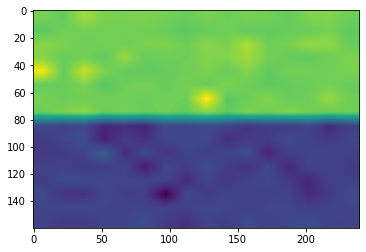

In [38]:
plt.imshow(output['pred'].cpu().detach().numpy()[0, 30])

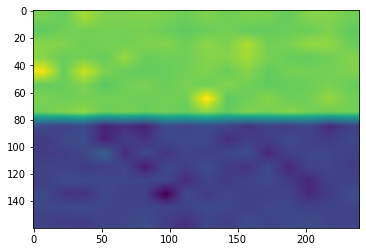

In [39]:
plt.imshow(output['pred'].cpu().detach().numpy()[0, 5])

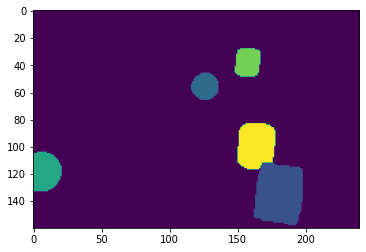

In [40]:
plt.imshow(mask[21].cpu())

In [41]:
mask[21].unique()

tensor([ 0., 12., 17., 29., 38., 48.], device='cuda:0')

In [42]:
torch.argmax(output['pred_masks'], 1)[40].unique()

tensor([0], device='cuda:0')

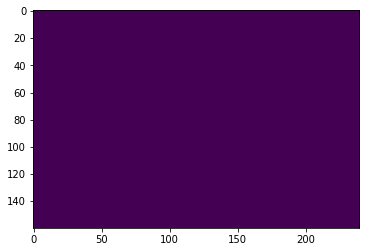

In [43]:
plt.imshow(torch.argmax(output['pred_masks'], 1).cpu().detach().numpy()[0])

In [44]:
output['pred_logits'].shape

torch.Size([44, 49, 49])

In [45]:
torch.argmax(output['pred'], 1)[4]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [46]:
output['pred_logits'].shape

torch.Size([44, 49, 49])

In [47]:
output['pred_masks'].shape

torch.Size([44, 49, 160, 240])

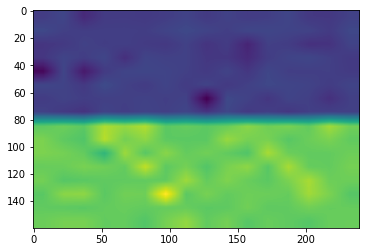

In [50]:
plt.imshow(output['pred_masks'].cpu().detach().numpy()[0, 0])

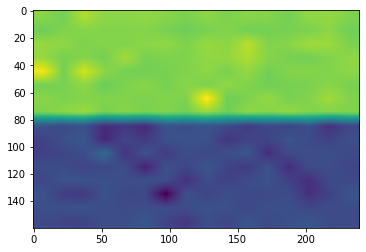

In [54]:
plt.imshow(output['pred_masks'].cpu().detach().numpy()[0, 25])

In [12]:
from decoders import DecoderSimple

In [22]:
decoder_simple = DecoderSimple(768, 49, 256, 160, 240)

In [23]:
decoder_simple.to(device)

DecoderSimple(
  (deconv1): ConvTranspose2d(768, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 49, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [24]:
num_epochs = 100
total_steps = num_epochs * len(dataloader)

# should these also come from global config?
div_factor = 5 # max_lr/div_factor = initial lr
final_div_factor = 10 # final lr is initial_lr/final_div_factor 
patience = 10

# Used this approach so that we can getv back to training the loaded model from checkpoint
epoch = 0

In [25]:
optimizer = torch.optim.AdamW(decoder_simple.parameters(), lr=0.0001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0.000001)

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
while epoch < num_epochs:
    decoder_simple.train()
    # do we need to do encoder.eval() or something? Since we are not training it, we want to deactivate the dropouts
    train_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels, target_masks = data 
        inputs, labels, target_masks = inputs.to(device), labels.to(device), target_masks.to(device)

        inputs = inputs[:, :11]

        optimizer.zero_grad()

        ### forward pass through encoder to get the embeddings
        predicted_embeddings = encoder(inputs.transpose(1, 2))

        # Reshape predicted embeddings to (b t) (h w) m
        predicted_embeddings = rearrange(predicted_embeddings, 'b (t n) m -> (b t) n m', t=22)
        target_masks = rearrange(target_masks, 'b t h w -> (b t) h w')

        ### forward pass through decoder to get the masks
        outputs = decoder_simple(predicted_embeddings)

        ### compute the loss and step
        loss = criterion(outputs, target_masks.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the scheduler learning rate
        scheduler.step()

    avg_epoch_loss = train_loss / len(dataloader)
    print(f'Epoch {epoch}, epoch loss : {avg_epoch_loss}')
    epoch += 1

Epoch 0, epoch loss : 1.0427517763376235
Epoch 1, epoch loss : 0.3941690524816513
Epoch 2, epoch loss : 0.3881005889773369
Epoch 3, epoch loss : 0.38676598951220514
Epoch 4, epoch loss : 0.3862171685397625
Epoch 5, epoch loss : 0.3860495480000973
Epoch 6, epoch loss : 0.38545672115683555
Epoch 7, epoch loss : 0.38468931630253794
Epoch 8, epoch loss : 0.38324734118580817
Epoch 9, epoch loss : 0.38215508916974067
Epoch 10, epoch loss : 0.38114062961935996
Epoch 11, epoch loss : 0.3803603850603104
Epoch 12, epoch loss : 0.3790467711389065
Epoch 13, epoch loss : 0.37828466096520424
Epoch 14, epoch loss : 0.3773249359130859
Epoch 15, epoch loss : 0.3767055166065693
Epoch 16, epoch loss : 0.37612551072239875
Epoch 17, epoch loss : 0.3758005430996418
Epoch 18, epoch loss : 0.37529799684882165
Epoch 19, epoch loss : 0.37451583886146544
Epoch 20, epoch loss : 0.3738894480764866
Epoch 21, epoch loss : 0.37347621548175813


KeyboardInterrupt: 

In [28]:
root_val = '/val/data/'
annotation_file_val = '/val/annotations.txt'

datasetval = VideoFrameDataset(
    root_path=root_val,
    annotationfile_path=annotation_file_val,
    num_segments=1,
    frames_per_segment=22,
    imagefile_template='image_{:d}.png',
    transform=preprocess,
    mask=True,
    test_mode=False
)

dataloader_val = torch.utils.data.DataLoader(
        dataset=datasetval,
        batch_size=2,
        shuffle=True,
        num_workers=1,
        pin_memory=True
    )

In [29]:
data, target, mask = next(iter(dataloader_val))
data, target, mask = data.to(device), target.to(device), mask.to(device)

In [30]:
pred = encoder(data.transpose(1, 2)[:,:,:11])

In [32]:
pred = rearrange(pred, 'b (t n) m -> (b t) n m', t=22)
pred.shape

torch.Size([44, 64, 768])

In [33]:
mask = rearrange(mask, 'b t n m -> (b t) n m')
mask.shape

torch.Size([44, 160, 240])

In [34]:
output = decoder_simple(pred)

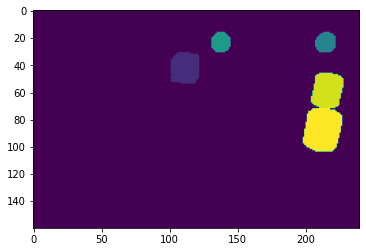

In [35]:
plt.imshow(mask[21].cpu())

In [36]:
output

tensor([[[[ 3.9982,  3.9982,  4.1470,  ...,  4.2882,  4.1225,  4.1225],
          [ 5.6589,  5.6589,  5.7784,  ...,  5.9327,  5.8794,  5.8794],
          [ 4.9515,  4.9515,  4.9074,  ...,  5.2268,  5.3352,  5.3352],
          ...,
          [ 4.7238,  4.7238,  4.6654,  ...,  4.9536,  5.0969,  5.0969],
          [ 5.3711,  5.3711,  5.4610,  ...,  5.5932,  5.6646,  5.6646],
          [ 3.9793,  3.9793,  4.1475,  ...,  4.2533,  4.1354,  4.1354]],

         [[-2.4203, -2.4203, -2.6069,  ..., -3.0636, -2.8339, -2.8339],
          [-3.0017, -3.0017, -3.3538,  ..., -4.0147, -3.7282, -3.7282],
          [-3.0790, -3.0790, -3.3170,  ..., -3.9663, -3.7263, -3.7263],
          ...,
          [-2.8336, -2.8336, -3.0252,  ..., -3.6524, -3.4666, -3.4666],
          [-3.3274, -3.3274, -3.4667,  ..., -3.6090, -3.3204, -3.3204],
          [-2.6457, -2.6457, -2.8463,  ..., -2.7672, -2.5225, -2.5225]],

         [[-3.0977, -3.0977, -3.2122,  ..., -2.7682, -2.6465, -2.6465],
          [-4.0649, -4.0649, -

In [40]:
torch.argmin(output, 1).unique()

tensor([ 2,  4,  6,  7, 10, 11, 12, 13, 14, 16, 20, 21, 24, 25, 27, 28, 29, 30,
        32, 34, 36, 38, 40, 42, 45, 48], device='cuda:0')

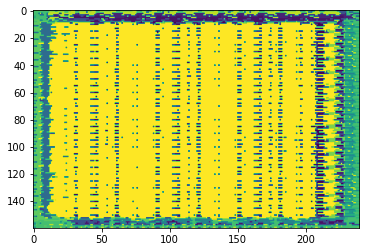

In [44]:
plt.imshow(torch.argmin(output, 1).cpu().detach().numpy()[5])